<a href="https://colab.research.google.com/github/disturbed-mystic1/DSC-253-Project/blob/main/RAG_BLEU_score_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLaMa - 3 Financial Analyst

---
In this notebook we will:
1. Fine tune a local model of LLaMa 3 on form 10-K Contextual Q&A Data using supervised fine tuning & Low Rank Adaptation
2. Set up an SEC Data pipeline to retrieve recent form 10-K's
3. Use local embedding and in memory vector stores to create a retrieval function
4. Combine everything above to make a simple financial analysis RAG agent!

Prepared by [Adam Lucek](https://www.youtube.com/@AdamLucek), Check out my [video walkthrough with this link](https://www.youtube.com/watch?v=GfjUJ1TnI-o) or by clicking on the video below
👇

[![Thumbnail](https://i.imgur.com/NAFuTvC.png)](https://www.youtube.com/watch?v=GfjUJ1TnI-o)

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### *Remember to change your runtime to the T4 GPU in the top right corner*


Installing Dependencies and Setting API Keys

In [2]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes
!pip install sec_api
!pip install -U langchain
!pip install -U langchain-community
!pip install -U sentence-transformers
!pip install -U faiss-gpu

HuggingFace Token Found: https://huggingface.co/settings/tokens  
Free SEC API Key Here: https://sec-api.io/

In [3]:
# HuggingFace token, required for accessing gated models (like LLaMa 3 8B Instruct)
hf_token = ""
# SEC-API Key
sec_api_key = ""

In [4]:
# Fine Tuning Related Packages
from unsloth import FastLanguageModel
import torch
from datasets import load_dataset
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

# Pipeline & RAG Related Packages
from sec_api import ExtractorApi, QueryApi
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


---
## **Part 1: Fine Tuning LLaMa 3 with Unsloth**

We will be using the built in GPU on Colab to do all our fine tuning needs, using the [Unsloth Library](https://github.com/unslothai/unsloth).

Much of the below code is augmented from [Unsloth Documentation!](https://colab.research.google.com/drive/135ced7oHytdxu3N2DNe1Z0kqjyYIkDXp?usp=sharing#scrollTo=AEEcJ4qfC7Lp)


### **Initializing Pre Trained Model and Tokenizer**

For this example we will be using Meta's [LLaMa 3 8b Instruct Model](https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct).  
 **NOTE**: This is a gated model, you must request access on HF and pass in your HF token in the below step.

In [5]:
# Load the model and tokenizer from the pre-trained FastLanguageModel
model, tokenizer = FastLanguageModel.from_pretrained(
    # Specify the pre-trained model to use
    # model_name = "meta-llama/Meta-Llama-3-8B-Instruct",
    model_name = "unsloth/mistral-7b-v0.3",

    # Specifies the maximum number of tokens (words or subwords) that the model can process in a single forward pass
    max_seq_length = 2048,
    # Data type for the model. None means auto-detection based on hardware, Float16 for specific hardware like Tesla T4
    dtype = None,
    # Enable 4-bit quantization, By quantizing the weights of the model to 4 bits instead of the usual 16 or 32 bits, the memory required to store these weights is significantly reduced. This allows larger models to be run on hardware with limited memory resources.
    load_in_4bit = True,
    # Access token for gated models, required for authentication to use models like Meta-Llama-2-7b-hf
    token = hf_token,
)


==((====))==  Unsloth 2024.12.4: Fast Gemma2 patching. Transformers:4.46.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

**Adding in LoRA adapters for parameter efficient fine tuning**

LoRA, or Low-Rank Adaptation, is a technique used in machine learning to fine-tune large models more efficiently. It works by adding a small, additional set of parameters to the existing model instead of retraining all the parameters from scratch. This makes the fine-tuning process faster and less resource-intensive. Essentially, LoRA helps tailor a pre-trained model to specific tasks or datasets without requiring extensive computational power or memory.

In [6]:
# Apply LoRA (Low-Rank Adaptation) adapters to the model for parameter-efficient fine-tuning
model = FastLanguageModel.get_peft_model(
    model,
    # Rank of the adaptation matrix. Higher values can capture more complex patterns. Suggested values: 8, 16, 32, 64, 128
    r = 16,
    # Specify the model layers to which LoRA adapters should be applied
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    # Scaling factor for LoRA. Controls the weight of the adaptation. Typically a small positive integer
    lora_alpha = 16,
    # Dropout rate for LoRA. A value of 0 means no dropout, which is optimized for performance
    lora_dropout = 0,
    # Bias handling in LoRA. Setting to "none" is optimized for performance, but other options can be used
    bias = "none",
    # Enables gradient checkpointing to save memory during training. "unsloth" is optimized for very long contexts
    use_gradient_checkpointing = "unsloth",
    # Seed for random number generation to ensure reproducibility of results
    random_state = 3407,
)

Unsloth 2024.12.4 patched 26 layers with 26 QKV layers, 26 O layers and 26 MLP layers.



1. **r**: The rank of the low-rank adaptation matrix. This determines the capacity of the adapter to capture additional information. Higher ranks allow capturing more complex patterns but also increase computational overhead.

2. **target_modules**: List of module names within the model to which the LoRA adapters should be applied. These modules typically include the projections within transformer layers (e.g., query, key, value projections) and other key transformation points.
  - **q_proj**: Projects input features to query vectors for attention mechanisms.
  - **k_proj**: Projects input features to key vectors for attention mechanisms.
  - **v_proj**: Projects input features to value vectors for attention mechanisms.
  - **o_proj**: Projects the output of the attention mechanism to the next layer.
  - **gate_proj**: Applies gating mechanisms to modulate the flow of information.
  - **up_proj**: Projects features to a higher dimensional space, often used in feed-forward networks.
  - **down_proj**: Projects features to a lower dimensional space, often used in feed-forward networks.

These layers are typically involved in transformer-based models, facilitating various projections and transformations necessary for the attention mechanism and feed-forward processes.

3. **lora_alpha**: A scaling factor for the LoRA adapter. It controls the impact of the adapter on the model's outputs. Typically set to a small positive integer.

4. **lora_dropout**: Dropout rate applied to the LoRA adapters. Dropout helps in regularizing the model, but setting it to 0 means no dropout, which is often optimal for performance.

5. **bias**: This specifies how biases should be handled in the LoRA adapters. Setting it to "none" indicates no bias is used, which is optimized for performance, although other options are available depending on the use case.

6. **use_gradient_checkpointing**: Enables gradient checkpointing, which helps to save memory during training by not storing all intermediate activations. "unsloth" is a setting optimized for very long contexts, but it can also be set to True.

7. **random_state**: A seed for the random number generator to ensure reproducibility. This makes sure that the results are consistent across different runs of the code.

### **Preparing the Fine Tuning Dataset**

We will be using a HF dataset of Financial Q&A over form 10ks, provided by user [Virat Singh](https://github.com/virattt) here https://huggingface.co/datasets/virattt/llama-3-8b-financialQA

The following code below formats the entries into the prompt defined first for training, being careful to add in special tokens. In this case our End of Sentence token is <|eot_id|>. More LLaMa 3 special tokens [here](https://llama.meta.com/docs/model-cards-and-prompt-formats/meta-llama-3/)

In [7]:
# Defining the expected prompt
ft_prompt = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
Below is a user question, paired with retrieved context. Write a response that appropriately answers the question,
include specific details in your response. <|eot_id|>

<|start_header_id|>user<|end_header_id|>

### Question:
{}

### Context:
{}

<|eot_id|>

### Response: <|start_header_id|>assistant<|end_header_id|>
{}"""

# Grabbing end of sentence special token
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

# Function for formatting above prompt with information from Financial QA dataset
def formatting_prompts_func(examples):
    questions = examples["question"]
    contexts       = examples["context"]
    responses      = examples["answer"]
    texts = []
    for question, context, response in zip(questions, contexts, responses):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = ft_prompt.format(question, context, response) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

dataset = load_dataset("virattt/llama-3-8b-financialQA", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

In [ ]:
dataset[0]

{'question': 'What area did NVIDIA initially focus on before expanding to other computationally intensive fields?',
 'answer': 'NVIDIA initially focused on PC graphics.',
 'context': 'Since our original focus on PC graphics, we have expanded to several other large and important computationally intensive fields.',
 'ticker': 'NVDA',
 'filing': '2023_10K',
 'text': '<|begin_of_text|><|start_header_id|>system<|end_header_id|>\nBelow is a user question, paired with retrieved context. Write a response that appropriately answers the question,\ninclude specific details in your response. <|eot_id|>\n\n<|start_header_id|>user<|end_header_id|>\n\n### Question:\nWhat area did NVIDIA initially focus on before expanding to other computationally intensive fields?\n\n### Context:\nSince our original focus on PC graphics, we have expanded to several other large and important computationally intensive fields.\n\n<|eot_id|>\n\n### Response: <|start_header_id|>assistant<|end_header_id|>\nNVIDIA initially

In [8]:
split_dataset = dataset.train_test_split(test_size=100, seed=42)
dataset = split_dataset['train']
test_dataset = split_dataset['test']

print(f"Length of train dataset: {len(dataset)}")
print(f"Length of test dataset: {len(test_dataset)}")

Length of train dataset: 6900
Length of test dataset: 100


### **Defining the Trainer Arguments**

We will be setting up and using HuggingFace Transformer Reinforcement Learning (TRL)'s [Supervised Fine-Tuning Trainer](https://huggingface.co/docs/trl/sft_trainer)

**Supervised fine-tuning** is a process in machine learning where a pre-trained model is further trained on a specific dataset with labeled examples. During this process, the model learns to make predictions or classifications based on the labeled data, improving its performance on the specific task at hand. This technique leverages the general knowledge the model has already acquired during its initial training phase and adapts it to perform well on a more targeted set of examples. Supervised fine-tuning is commonly used to customize models for specific applications, such as sentiment analysis, object recognition, or language translation, by using task-specific annotated data.

In [9]:
trainer = SFTTrainer(
    # The model to be fine-tuned
    model = model,
    # The tokenizer associated with the model
    tokenizer = tokenizer,
    # The dataset used for training
    train_dataset = dataset,
    # The field in the dataset containing the text data
    dataset_text_field = "text",
    # Maximum sequence length for the training data
    max_seq_length = 2048,
    # Number of processes to use for data loading
    dataset_num_proc = 2,
    # Whether to use sequence packing, which can speed up training for short sequences
    packing = False,
    args = TrainingArguments(
        # Batch size per device during training
        per_device_train_batch_size = 2,
        # Number of gradient accumulation steps to perform before updating the model parameters
        gradient_accumulation_steps = 4,
        # Number of warmup steps for learning rate scheduler
        warmup_steps = 5,
        # Total number of training steps
        max_steps = 30,
        # Number of training epochs, can use this instead of max_steps, for this notebook its ~900 steps given the dataset
        # num_train_epochs = 1,
        # Learning rate for the optimizer
        learning_rate = 2e-4,
        # Use 16-bit floating point precision for training if bfloat16 is not supported
        fp16 = not is_bfloat16_supported(),
        # Use bfloat16 precision for training if supported
        bf16 = is_bfloat16_supported(),
        # Number of steps between logging events
        logging_steps = 1,
        # Optimizer to use (in this case, AdamW with 8-bit precision)
        optim = "adamw_8bit",
        # Weight decay to apply to the model parameters
        weight_decay = 0.01,
        # Type of learning rate scheduler to use
        lr_scheduler_type = "linear",
        # Seed for random number generation to ensure reproducibility
        seed = 3407,
        # Directory to save the output models and logs
        output_dir = "outputs",
    ),
)


Map (num_proc=2):   0%|          | 0/6900 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


1. **model**: The model to be fine-tuned. This is the pre-trained model that will be adapted to the specific training data.

2. **tokenizer**: The tokenizer associated with the model. It converts text data into tokens that the model can process.

3. **train_dataset**: The dataset used for training. This is the collection of labeled examples that the model will learn from during the fine-tuning process.

4. **dataset_text_field**: The field in the dataset containing the text data. This specifies which part of the dataset contains the text that the model will be trained on.

5. **max_seq_length**: The maximum sequence length for the training data. This limits the number of tokens per input sequence to ensure they fit within the model's processing capacity.

6. **dataset_num_proc**: The number of processes to use for data loading. This can speed up data loading by parallelizing it across multiple processes.

7. **packing**: A boolean indicating whether to use sequence packing. Sequence packing can speed up training by combining multiple short sequences into a single batch.

8. **args**: A set of training arguments that configure the training process. These include various hyperparameters and settings:

    - **per_device_train_batch_size**: The batch size per device during training. This determines how many examples are processed together in one forward/backward pass.
    
    - **gradient_accumulation_steps**: The number of gradient accumulation steps to perform before updating the model parameters. This allows for effectively larger batch sizes without requiring more memory.
    
    - **warmup_steps**: The number of warmup steps for the learning rate scheduler. During these steps, the learning rate increases gradually to the initial value.
    
    - **max_steps**: The total number of training steps. This defines how many batches of training data the model will be trained on.
    
    - **num_train_epochs**: The number of training epochs (uncommented in the example). This defines how many times the entire training dataset will be passed through the model.
    
    - **learning_rate**: The learning rate for the optimizer. This controls how much to adjust the model's weights with respect to the gradient during training.
    
    - **fp16**: A boolean indicating whether to use 16-bit floating point precision for training if bfloat16 is not supported. This can speed up training and reduce memory usage.
    
    - **bf16**: A boolean indicating whether to use bfloat16 precision for training if supported. This can also speed up training and reduce memory usage while maintaining higher precision than fp16.
    
    - **logging_steps**: The number of steps between logging events. This controls how frequently training progress and metrics are logged.
    
    - **optim**: The optimizer to use. In this case, AdamW with 8-bit precision, which can improve efficiency for large models.
    
    - **weight_decay**: The weight decay to apply to the model parameters. This is a regularization technique to prevent overfitting by penalizing large weights.
    
    - **lr_scheduler_type**: The type of learning rate scheduler to use. This controls how the learning rate changes over time during training.
    
    - **seed**: The seed for random number generation. This ensures reproducibility of results by controlling the randomness in training.
    
    - **output_dir**: The directory to save the output models and logs. This specifies where the trained model and training logs will be stored.

# **Now We're Ready to Train!** 🎉

In [10]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 6,900 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 30
 "-____-"     Number of trainable parameters = 20,766,720
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tramesh (tramesh-uc-san-diego). Use `wandb login --relogin` to force relogin


Step,Training Loss
1,2.151800
2,2.093100
3,2.173200
4,1.908100
5,1.663000
6,1.483900
7,1.102800
8,1.132000
9,0.870900
10,0.805900


---
### **Saving Your Fine-Tuned Model Locally**

First click on files, then mount drive to connect google drive! Create a folder and replace with path below

In [11]:
model.save_pretrained("/content/drive/MyDrive/DSC253/mistral/mistral_step30") # Local saving
tokenizer.save_pretrained("/content/drive/MyDrive/DSC253/mistral/mistral_step30")

('/content/drive/MyDrive/DSC253/gemma/gemma_step30/tokenizer_config.json',
 '/content/drive/MyDrive/DSC253/gemma/gemma_step30/special_tokens_map.json',
 '/content/drive/MyDrive/DSC253/gemma/gemma_step30/tokenizer.model',
 '/content/drive/MyDrive/DSC253/gemma/gemma_step30/added_tokens.json',
 '/content/drive/MyDrive/DSC253/gemma/gemma_step30/tokenizer.json')

### **Function for Loading Your New Model Later**

So you don't have to retrain every time, just turn False to True and run this. One note, Colab deletes all files, so mount your google drive and save to a folder there to keep it persistent!

You'll still need to download and run the python packages from the top of the notebook, and also re define the prompt for the inference functions down below

In [12]:
# Redefining prompt if importing without training
ft_prompt = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
Below is a user question, paired with retrieved context. Write a response that appropriately answers the question,
include specific details in your response. <|eot_id|>

<|start_header_id|>user<|end_header_id|>

### Question:
{}

### Context:
{}

<|eot_id|>

### Response: <|start_header_id|>assistant<|end_header_id|>
{}"""

if False: # switch to true to load model back up
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "/content/drive/MyDrive/l3_finagent/l3_finagent_step60", # Path into where you saved your model
        max_seq_length = 2048, # Existing arguments from when we loaded earlier
        dtype = None,
        load_in_4bit = True,
    )
    FastLanguageModel.for_inference(model)

### **Setting Up Functions for Running Inference**

**Inference** refers to the process of using a trained machine learning model to make predictions or generate outputs based on new, unseen input data. It involves feeding the input data into the model and obtaining the model's predictions, classifications, or generated text, depending on the task the model is designed for. Inference is the application phase of the model, as opposed to the training phase.

In [13]:
# Main Inference Function, handles generating and decoding tokens
def inference(question, context):
  inputs = tokenizer(
  [
      ft_prompt.format(
          question,
          context,
          "", # output - leave this blank for generation!
      )
  ], return_tensors = "pt").to("cuda")

  # Generate tokens for the input prompt using the model, with a maximum of 64 new tokens.
  # The `use_cache` parameter enables faster generation by reusing previously computed values.
  # The `pad_token_id` is set to the EOS token to handle padding properly.
  outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True, pad_token_id=tokenizer.eos_token_id)
  response = tokenizer.batch_decode(outputs) # Decoding tokens into english words
  return response

In [14]:
# Function for extracting just the language model generation from the full response
def extract_response(text):
    text = text[0]
    start_token = "### Response: <|start_header_id|>assistant<|end_header_id|>"
    end_token = "<|eot_id|>"

    start_index = text.find(start_token) + len(start_token)
    end_index = text.find(end_token, start_index)

    if start_index == -1 or end_index == -1:
        return None

    return text[start_index:end_index].strip()

In [15]:
FastLanguageModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Gemma2ForCausalLM(
      (model): Gemma2Model(
        (embed_tokens): Embedding(256000, 2304, padding_idx=0)
        (layers): ModuleList(
          (0-25): 26 x Gemma2DecoderLayer(
            (self_attn): Gemma2Attention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2304, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2304, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

In [16]:
# Testing it out!
context = "The increase in research and development expense for fiscal year 2023 was primarily driven by increased compensation, employee growth, engineering development costs, and data center infrastructure."
question = "What were the primary drivers of the notable increase in research and development expenses for fiscal year 2023?"

resp = inference(question, context)
parsed_response = extract_response(resp)
print(parsed_response)

None


In [17]:
print(resp)

['<bos><|begin_of_text|><|start_header_id|>system<|end_header_id|>\nBelow is a user question, paired with retrieved context. Write a response that appropriately answers the question,\ninclude specific details in your response. <|eot_id|>\n\n<|start_header_id|>user<|end_header_id|>\n\n### Question:\nWhat were the primary drivers of the notable increase in research and development expenses for fiscal year 2023?\n\n### Context:\nThe increase in research and development expense for fiscal year 2023 was primarily driven by increased compensation, employee growth, engineering development costs, and data center infrastructure.\n\n<|eot_id|>\n\n### Response: <|start_header_id|>assistant<|end_header_id|>\nThe primary drivers of the notable increase in research and development expenses for fiscal year 2023 were increased compensation, employee growth, engineering development costs, and data center infrastructure.<eos>']


---
# **Part 2: Setting Up SEC 10-K Data Pipeline & Retrieval Functionality**

Now that we have our fine tuned language model, inference functions, and a desired prompt format, we need to now set up the RAG pipeline to inject the relevant context into each generation.

The flow will follow as such:

*User Question* -> *Context Retrieval from 10-K* -> *LLM Answers User Question Using Context*

To do this we will need to be able to:
1. Gather specific from 10-K's
2. Parse and chunk the text in them
3. Vectorize and embed the chunks into a vector Database
4. Set up a retriever to semantically search the user's questions over the database to return relevant context

A **Form 10-K** is an annual report required by the U.S. Securities and Exchange Commission, that gives a comprehensive summary of a company's financial performance.

### **Function For 10-K Retrieval**

To do this easier, we're taking advantage of the SEC API https://sec-api.io/. It is free to sign up, and you get 100 API calls a day to use, each time we load a ticker's symbol it will use 3 calls.

For this project, we'll be focused on loading only sections **1A** and **7**
- **1A**: Risk Factors
- **7**: Management's Discussion and Analysis of Financial Condition and Results of Operations

In [18]:
# Extract Filings Function
def get_filings(ticker):
    global sec_api_key

    # Finding Recent Filings with QueryAPI
    queryApi = QueryApi(api_key=sec_api_key)
    query = {
      "query": f"ticker:{ticker} AND formType:\"10-K\"",
      "from": "0",
      "size": "1",
      "sort": [{ "filedAt": { "order": "desc" } }]
    }
    filings = queryApi.get_filings(query)

    # Getting 10-K URL
    filing_url = filings["filings"][0]["linkToFilingDetails"]

    # Extracting Text with ExtractorAPI
    extractorApi = ExtractorApi(api_key=sec_api_key)
    onea_text = extractorApi.get_section(filing_url, "1A", "text") # Section 1A - Risk Factors
    seven_text = extractorApi.get_section(filing_url, "7", "text") # Section 7 - Management’s Discussion and Analysis of Financial Condition and Results of Operations

    # Joining Texts
    combined_text = onea_text + "\n\n" + seven_text

    return combined_text

### **Setting Up Embeddings Locally**

In the spirit of local and fine tuned models, we'll be using an open source embedding model, [Beijing Academy of Artificial Intelligence's - Large English Embedding Model](https://huggingface.co/BAAI/bge-large-en-v1.5). More details on their open source model available in their [GitHub repo](https://github.com/FlagOpen/FlagEmbedding)!

**Embeddings** are numerical representations of data, typically used to convert complex, high-dimensional data into a lower-dimensional space where similar data points are closer together. In the context of natural language processing (NLP), embeddings are used to represent words, phrases, or sentences as vectors of real numbers. These vectors capture semantic relationships, meaning that words with similar meanings are represented by vectors that are close together in the embedding space.

**Embedding models** are machine learning models that are trained to create these numerical representations. They learn to encode various types of data into embeddings that capture the essential characteristics and relationships within the data. For example, in NLP, embedding models like Word2Vec, GloVe, and BERT are trained on large text corpora to produce word embeddings. These embeddings can then be used for various downstream tasks, such as text classification, sentiment analysis, or machine translation. In this case we'll be using it for semantic similarity

In [19]:
# HF Model Path
modelPath = "BAAI/bge-large-en-v1.5"
# Create a dictionary with model configuration options, specifying to use the cuda for GPU optimization
model_kwargs = {'device':'cuda'}
encode_kwargs = {'normalize_embeddings': True}

# Initialize an instance of LangChain's HuggingFaceEmbeddings with the specified parameters
embeddings = HuggingFaceEmbeddings(
    model_name=modelPath,     # Provide the pre-trained model's path
    model_kwargs=model_kwargs, # Pass the model configuration options
    encode_kwargs=encode_kwargs # Pass the encoding options
)

<ipython-input-19-7da35b4063b5>:8: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


### **Processing & Defining the Vector Database**

In this flow we get the data from the above defined SEC API functions, and then go through Three steps:
1. Text Splitting
2. Vectorizing
3. Retrieval Function Setup

**Text splitting** is the process of breaking down large documents or text data into smaller, manageable chunks. This is often necessary when dealing with extensive text data, such as legal documents, financial reports, or any lengthy articles. The purpose of text splitting is to ensure that the data can be effectively processed, analyzed, and indexed by machine learning models and databases.

**Vector databases** store data in the form of vectors, which are numerical representations of text, images, or other types of data. These vectors capture the semantic meaning of the data, allowing for efficient similarity search and retrieval.

The Vector DB we're using here is the [Facebook AI Semantic Search](https://ai.meta.com/tools/faiss/) library, a lightweight an in memory (don't need to save this to a disk) solution that is not as powerful as other Vector DB's but will work great for this use case

**How They Use Split Documents and Embeddings Together:**
1. **Embeddings:** When text data is split into smaller chunks, each chunk is converted into a numerical vector (embedding) using an embedding model. These embeddings capture the semantic relationships and meaning of the text.
2. **Storage:** The vector database stores these embeddings along with references to the original text chunks.
3. **Indexing:** The database indexes the vectors to allow for fast and efficient similarity searches. This indexing process organizes the vectors in a way that makes it easy to find similar vectors quickly.
4. **Usage:** When a query is made, the vector database searches for the most similar vectors (text chunks) to the query vector, retrieving the relevant text chunks based on their semantic similarity.

In [20]:
# Prompt the user to input the stock ticker they want to analyze
ticker = input("What Ticker Would you Like to Analyze? ex. AAPL: ")

print("-----")
print("Getting Filing Data")
# Retrieve the filing data for the specified ticker
filing_data = get_filings(ticker)

print("-----")
print("Initializing Vector Database")
# Initialize a text splitter to divide the filing data into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,         # Maximum size of each chunk
    chunk_overlap = 500,       # Number of characters to overlap between chunks
    length_function = len,     # Function to determine the length of the chunks
    is_separator_regex = False # Whether the separator is a regex pattern
)
# Split the filing data into smaller, manageable chunks
split_data = text_splitter.create_documents([filing_data])

# Create a FAISS vector database from the split data using embeddings
db = FAISS.from_documents(split_data, embeddings)

# Create a retriever object to search within the vector database
retriever = db.as_retriever(
    # search_type="mmr",
)

print("-----")
print("Filing Initialized")


What Ticker Would you Like to Analyze? ex. AAPL: AAPL
-----
Getting Filing Data
-----
Initializing Vector Database
-----
Filing Initialized



### **Retrieval**

**Description:**
Retrieval is the process of querying a vector database to find and return relevant text chunks or documents that match a given query. This involves searching through the indexed embeddings to identify the ones that are most similar to the query.

**How It Works:**
1. **Query Embedding:** When a query is made, it is first converted into an embedding using the same embedding model used for the text chunks.
2. **Similarity Search:** The retriever searches the vector database for embeddings that are similar to the query embedding. This similarity is often measured using distance metrics like cosine similarity or Euclidean distance.
3. **Document Retrieval:** The retriever then retrieves the original text chunks or documents associated with the similar embeddings.
4. **Context Assembly:** The retrieved text chunks are assembled to provide a coherent context or answer to the query.

In this function, the query is used to invoke the retriever, which returns a list of documents. The content of these documents is then extracted and returned as the context for the query.

In [21]:
# Retrieval Function
def retrieve_context(query):
    global retriever
    retrieved_docs = retriever.invoke(query) # Invoke the retriever with the query to get relevant documents
    context = []
    for doc in retrieved_docs:
        context.append(doc.page_content) # Collect the content of each retrieved document
    return context

In [22]:
context = retrieve_context("How have currency fluctuations impacted the company's net sales and gross margins?")
print(context)

['The weakening of foreign currencies relative to the U.S. dollar adversely affects the U.S. dollar value of the Company&#8217;s foreign currency&#8211;denominated sales and earnings, and generally leads the Company to raise international pricing, potentially reducing demand for the Company&#8217;s products. In some circumstances, for competitive or other reasons, the Company may decide not to raise international pricing to offset the U.S. dollar&#8217;s strengthening, which would adversely affect the U.S. dollar value of the gross margins the Company earns on foreign currency&#8211;denominated sales.', 'The Company&#8217;s profit margins vary across its products, services, geographic segments and distribution channels. For example, the gross margins on the Company&#8217;s products and services vary significantly and can change over time. The Company&#8217;s gross margins are subject to volatility and downward pressure due to a variety of factors, including: continued industry-wide glo

---
# **Main Script: Putting it All Together!**

Now, we'll string everything together into a very simple while loop that will take the user's question, retrieve context from the Vector DB populated with the specific company Form 10-K, then run inference through our fine tuned model to generate a response! Give it a shot

In [ ]:
while True:
  question = input(f"What would you like to know about {ticker}'s form 10-K? ")
  if question == "x":
    break
  else:
    context = retrieve_context(question) # Context Retrieval
    resp = inference(question, context) # Running Inference
    parsed_response = extract_response(resp) # Parsing Response
    print(f"L3 Agent: {parsed_response}")
    print("-----\n")


What would you like to know about AAPL's form 10-K? What region contributes most to international sales?
L3 Agent: The Americas region contributes the most to international sales.
-----

What would you like to know about AAPL's form 10-K? Where is outsourcing located currently?
L3 Agent: The Company outsources manufacturing to partners primarily located in China mainland, India, Japan, South Korea, Taiwan, and Vietnam.
-----

What would you like to know about AAPL's form 10-K? Does the US dollar weakening help or hurt the company?
L3 Agent: None
-----

What would you like to know about AAPL's form 10-K? What are significant announcements of products during fiscal year 2023?
L3 Agent: During fiscal year 2023, Apple announced the following significant products: iPad and iPad Pro, Next-generation Apple TV 4K, and MLS Season Pass, a Major League Soccer subscription streaming service.
-----

What would you like to know about AAPL's form 10-K? iPhone Net Sales?
L3 Agent: iPhone net sales dec

In [23]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
import numpy as np

bleu_scores = []
references = []
candidates = []
# Loop through each question, context, and answer tuple in test_dataset
for i,item in enumerate(test_dataset):
    question = item['question']
    true_answer = item['answer']
    context = item['context']

    # Run the RAG process
    retrieved_context = retrieve_context(question)  # Context retrieval
    generated_response = inference(question, retrieved_context)  # Inference
    parsed_response = extract_response(generated_response)  # Parsing response

    # Calculate BLEU score between generated response and true answer
    reference = [true_answer.split()] if true_answer else [] # Tokenized reference answer
    candidate = parsed_response.split() if parsed_response else [] # Tokenized model response
    references.append(reference)
    candidates.append(candidate)

    # weights = (0.3,0.7,0,0)
    # bleu_score = sentence_bleu(reference, candidate, weights)

    # Append BLEU score to list
    # bleu_scores.append(bleu_score)

    print(f"{i}")


    # Optional: Print the question, response, and BLEU score
    # print(f"Question: {question}")
    # print(f'Retriened Context: {retrieved_context}')
    # print(f'Context: {context}')
    # print(f'Generated response: {generated_response}')
    # print(f"Generated Answer: {parsed_response}")
    # print(f"True Answer: {true_answer}")
    # print(f"BLEU Score: {bleu_score}\n")
    # print("-----\n")


# average_bleu_score = np.mean(bleu_scores)
# print(f"Average BLEU Score on test dataset: {average_bleu_score}")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [24]:
smooth_fn = SmoothingFunction().method1
# weights = (0.25, 0.25, 0.25, 0.25)
weights = (0.3, 0.7, 0, 0 )
corpus_bleu_score = corpus_bleu(references, candidates, weights=weights, smoothing_function=smooth_fn)
print(f"Corpus BLEU Score on test dataset: {corpus_bleu_score:.4f}")

Corpus BLEU Score on test dataset: 0.0000


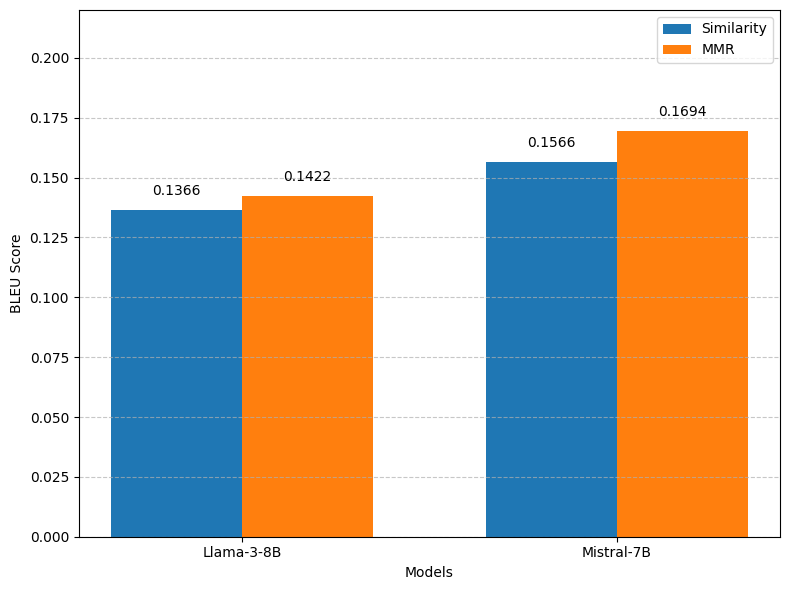

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Llama-3-8B', 'Mistral-7B']
similarity_scores = [0.1366, 0.1566]
mmr_scores = [0.1422, 0.1694]

# Bar width and positions
x = np.arange(len(models))
bar_width = 0.35

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - bar_width / 2, similarity_scores, bar_width, label='Similarity', )
bars2 = ax.bar(x + bar_width / 2, mmr_scores, bar_width, label='MMR', )

# Add text annotations for the scores
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{bar.get_height():.4f}', ha='center', va='bottom')
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{bar.get_height():.4f}', ha='center', va='bottom')

# Customizations
ax.set_xlabel('Models')
ax.set_ylabel('BLEU Score')
ax.set_ylim(0,0.22)
# ax.set_title('BLEU score ')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


What region contributes most to international sales?  
Where is outsourcing located currently?  
Does the US dollar weakening help or hurt the company?  
What are significant announcements of products during fiscal year 2023?  
iPhone Net Sales?


---
### Some thoughts
1. Really shows just how much processing is needed for training and running large, advanced models.
2. Even with a 16gb VRAM GPU still takes an hour to train one epoch, on just an 8 billion parameter small model with a narrow dataset
3. Even with all this time and effort put in, small models can be very powerful!
4. Latency is a big issue to solve in the lack of compute
5. A lot of innacuracy likely also due to 2048 token sequence length requirement

---
# Disclaimer

The information provided from this notebook is for educational purposes only and does not constitute financial advice. I do not provide personalized investment, financial, or legal advice. All financial products, services, and investments carry inherent risks, and you should conduct your own research or consult with a qualified financial advisor before making any financial decisions. I am not responsible for any losses or damages that may arise from the use of the information provided on this platform. Always consider your individual financial situation and objectives before making any investment or financial decision.